In [10]:
## Imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from audiolazy import str2midi, midi2str
from midiutil import MIDIFile

In [11]:
class ObjectPosition:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_dict(self):
        return {
            'x': self.x,
            'y': self.y,
        }

,x,y
0,505,1003
1,538,962
2,875,961
3,664,910
4,569,895
5,574,877
6,495,866
7,5,806
8,498,795
9,885,791


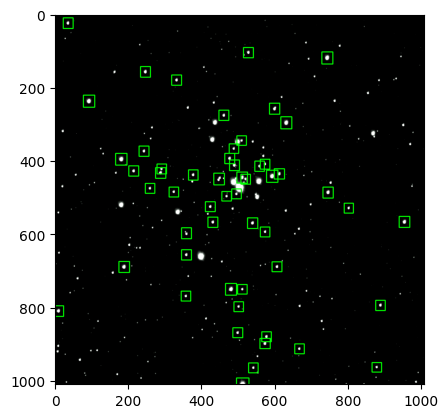

In [12]:
lower_bound = 20
upper_bound = 100

objects = []
# source data
img_file = "images/trifid1(cropped).jpg"

# create an OpenCV image
img = cv2.imread(img_file)

# convert color image to grey image
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

im_gauss = cv2.GaussianBlur(gray_img, (5, 5), 0)
ret, thresh = cv2.threshold(im_gauss, 127, 255, 0)
# get contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

margin = 10
# calculate area and filter
for con in contours:
    area = cv2.contourArea(con)
    if lower_bound < area < upper_bound:
        x,y,w,h = cv2.boundingRect(con)
        objects.append(ObjectPosition(x, y))
        cv2.rectangle(img, (x-margin, y-margin), (x + w+margin, y + h+margin), (0,255,0), 2)

plt.imshow(img, cmap='gray')
df = pd.DataFrame.from_records([object.to_dict() for object in objects])
display(df)

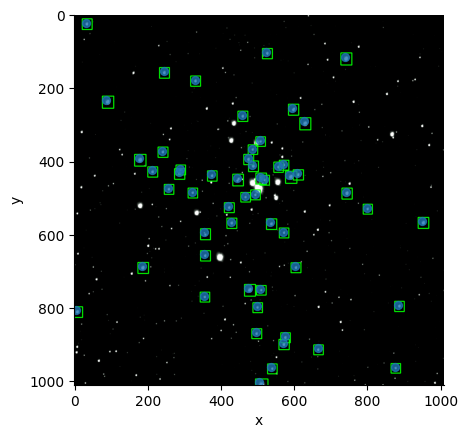

In [13]:
# @title x vs y
df.plot(kind='scatter', y='y', x='x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.imshow(img, cmap='gray')

In [14]:
# y = time
# x = pitch
# width = velocity


def map_value(value, min_value, max_value, min_result, max_result):
 # maps value (or array of values) from one range to another
 result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
 print(result)
 return result


duration_beats = 52.8 # how long in beats should this be

bpm = 128  #beats per minute
duration_sec = duration_beats*60/bpm #duration in seconds

print(duration_sec)

# C major scale
#note_names = ['C2','D2','E2','F2','G2','A2','B2',
 #            'C3','D3','E3','F3','G3','A3','B3',
 #            'C4','D4','E4','F4','G4','A4','B4']

# C lydian
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

# map midi notes to each of the notes I have selected
note_midis = [str2midi(n) for n in note_names]
n_notes = len(note_midis)

24.75


10.292939936775552
9.527924130663857
1.7154899894625935
6.60695468914647
8.80927291886196
8.693361433087459
10.524762908324552
21.8840885142255
10.455216016859852
1.483667017913593
13.793466807165437
10.223393045310853
10.98840885142255
8.044257112750262
17.734457323498418
13.770284510010537
13.770284510010537
8.78609062170706
9.597471022128556
12.101159114857746
0.0
3.4773445732349835
12.263435194942044
11.220231822971549
10.594309799789253
4.821917808219176
14.558482613277135
16.06533192834563
10.014752370916755
11.730242360379346
10.269757639620652
8.391991570073762
13.32982086406744
7.905163329820866
15.41622760800843
17.10853530031612
15.32349841938883
9.13382507903056
10.733403582718651
8.78609062170706
11.03477344573235
17.94309799789252
16.459430979978926
10.756585879873551
10.269757639620652
7.487881981032665
11.405690200210747
8.206533192834563
19.98314014752371
14.396206533192835
16.366701791359326
4.891464699683876
9.852476290832454
21.2581664910432


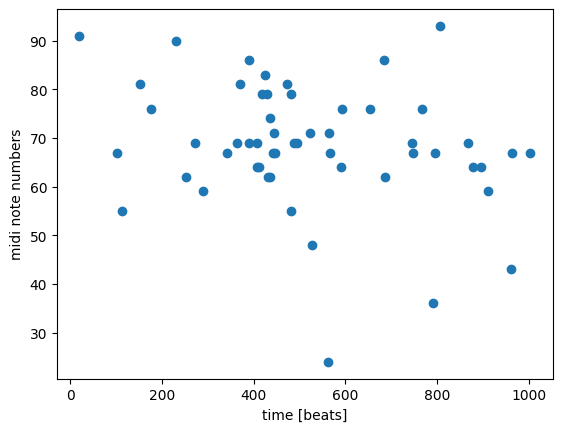

In [15]:
midi_data = []

def map_value(value, min_value, max_value, min_result, max_result):
 # maps value (or array of values) from one range to another
 result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
 print(result)
 return result

x_data = [obj.x for obj in objects] #pitch
t_data = [obj.y for obj in objects] #time

for i in range(len(x_data)):
    note_index = round(map_value(x_data[i], 0, max(x_data), n_notes-1, 0))
    midi_data.append(note_midis[note_index])

plt.scatter(t_data, midi_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

In [16]:
#create midi file object, add tempo
filename = 'midi/test'
my_midi_file = MIDIFile(1) #one track
my_midi_file.addTempo(track=0, time=0, tempo=bpm)

#add midi notes
for i in range(len(t_data)):
    my_midi_file.addNote(track=0, channel=0, time=t_data[i]/4, pitch=midi_data[i], volume=127, duration=2)

#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f)